# 05 — Fusion head
Load cached artifacts from previous steps and train a late-fusion or hybrid-fusion head.
**TODO**: verify file presence in `cache/` before training.


In [11]:
import numpy as np
import json
import pandas as pd
from pathlib import Path
import sys

sys.path.append(str(Path('..').resolve()))  # <-- make utils importable
from utils.paths import CACHE_DIR


CACHE_DIR.mkdir(parents=True, exist_ok=True)
print(f'Reading cache from: {CACHE_DIR.resolve()}')

_DEF_FILL = 0.0

LEX_PROBS_PATH = CACHE_DIR / 'lex_probs.parquet'
# LEX_PROBS_PATH = CACHE_DIR / 'lex_probs_lightgbm.parquet'  # Uncomment to use LightGBM export

AUDIO_PROBS_PATH = Path('../artifacts/phase1/audio_cnn/per_sample_probs.parquet')
if not AUDIO_PROBS_PATH.exists():
    AUDIO_PROBS_PATH = CACHE_DIR / 'audio_probs.parquet'

_MODAL_FILES = {
    'face': CACHE_DIR / 'face_probs_resnet50_gpu.parquet',
    'lex': LEX_PROBS_PATH,
    'emotion': CACHE_DIR / 'emotion_probs.parquet',
    'audio': AUDIO_PROBS_PATH,
}

_DROP_COLS = {'label', 'split', 'text', 'raw_text', 'file_path', 'path'}

def _maybe_read(path: Path) -> pd.DataFrame:
    if path.exists():
        return pd.read_parquet(path)
    print(f"[WARN] Missing cached modal features at {path}")
    return pd.DataFrame(columns=['sample_id'])


def _prepare_modal(df: pd.DataFrame, prefix: str, sample_ids: pd.Index) -> pd.DataFrame:
    if df.empty:
        return df
    df = df[df['sample_id'].isin(sample_ids)].copy()
    drop_cols = [c for c in _DROP_COLS if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = df.sort_values('sample_id').drop_duplicates(subset='sample_id', keep='last')
    rename_map = {c: f"{prefix}_{c}" for c in df.columns if c != 'sample_id' and not c.startswith(f"{prefix}_")}
    df = df.rename(columns=rename_map)
    return df


def load_feats(split: str = 'train'):
    split = split.lower()
    if split in {'val', 'validation'}:
        split = 'validation'
    text_path = CACHE_DIR / f"text_probs_{split}.parquet"
    emb_path = CACHE_DIR / f"text_emb_{split}.npy"
    if not text_path.exists():
        if split == 'test':
            print(f"[WARN] Missing text probabilities for split='{split}' at {text_path}; skipping.")
            return None, None
        raise FileNotFoundError(f"Missing text probabilities for split='{split}' at {text_path}")
    if not emb_path.exists():
        if split == 'test':
            print(f"[WARN] Missing text embeddings for split='{split}' at {emb_path}; skipping.")
            return None, None
        raise FileNotFoundError(f"Missing text embeddings for split='{split}' at {emb_path}")

    base = pd.read_parquet(text_path).copy()

    labels = base.set_index('sample_id')['label'].copy()
    drop_from_base = [c for c in ('split', 'text', 'raw_text') if c in base.columns]
    if drop_from_base:
        base = base.drop(columns=drop_from_base)
    features = base.set_index('sample_id').drop(columns=['label'])
    sample_ids = features.index

    for prefix, path in _MODAL_FILES.items():
        modal = _prepare_modal(_maybe_read(path), prefix, sample_ids)
        if modal.empty:
            continue
        modal = modal.set_index('sample_id')
        features = features.join(modal, how='left')

    features = features.fillna(_DEF_FILL)
    features['label'] = labels
    features = features.reset_index().rename(columns={'index': 'sample_id'})

    embeddings = np.load(emb_path)
    if len(features) != len(embeddings):
        raise ValueError(
            f"Embedding count ({len(embeddings)}) does not match dataframe rows ({len(features)})."
        )

    return features, embeddings


train_feats, train_emb = load_feats('train')
val_feats, val_emb = load_feats('validation')
test_feats, test_emb = load_feats('test')

if train_feats is None or val_feats is None:
    raise RuntimeError('Training and validation splits are required to train the fusion model.')

split_sizes = {
    'train_rows': len(train_feats),
    'val_rows': len(val_feats),
}
if test_feats is not None:
    split_sizes['test_rows'] = len(test_feats)
else:
    print('[WARN] Test split artifacts not found; fusion evaluation will skip test metrics.')

print(split_sizes)


Reading cache from: /Users/mixberries13/Desktop/is424/G2T2-emojis-to-emotions/cache
[WARN] Missing cached modal features at /Users/mixberries13/Desktop/is424/G2T2-emojis-to-emotions/cache/audio_probs.parquet
[WARN] Missing cached modal features at /Users/mixberries13/Desktop/is424/G2T2-emojis-to-emotions/cache/audio_probs.parquet
[WARN] Missing cached modal features at /Users/mixberries13/Desktop/is424/G2T2-emojis-to-emotions/cache/audio_probs.parquet
{'train_rows': 36601, 'val_rows': 4575, 'test_rows': 4576}


In [12]:
from pathlib import Path
import json
audio_metrics_path = Path('../artifacts/phase1/audio_cnn/validation_metrics.json')
if audio_metrics_path.exists():
    with audio_metrics_path.open() as f:
        audio_metrics = json.load(f)
    print('Loaded audio validation metrics:')
    print({key: audio_metrics[key] for key in ['average_val_accuracy', 'std_val_accuracy', 'average_clean_train_accuracy'] if key in audio_metrics})
else:
    print('[WARN] audio validation metrics not found at', audio_metrics_path)


[WARN] audio validation metrics not found at ../artifacts/phase1/audio_cnn/validation_metrics.json


Class distribution in training set:
  Class 0 (non_bullying): 6278 samples (17.15%)
  Class 1 (bullying): 30323 samples (82.85%)

VALIDATION METRICS (Logistic Regression Fusion)
Decision Threshold: 0.4
              precision    recall  f1-score   support

non_bullying       0.63      0.71      0.67       784
    bullying       0.94      0.92      0.93      3791

    accuracy                           0.88      4575
   macro avg       0.79      0.81      0.80      4575
weighted avg       0.89      0.88      0.88      4575

ROC-AUC (val): 0.9252879402882228

Confusion matrix (val):
[[ 557  227]
 [ 322 3469]]

Error Analysis:
  False Positive Rate (innocent flagged): 28.95% (227/784)
  False Negative Rate (bullying missed): 8.49% (322/3791)


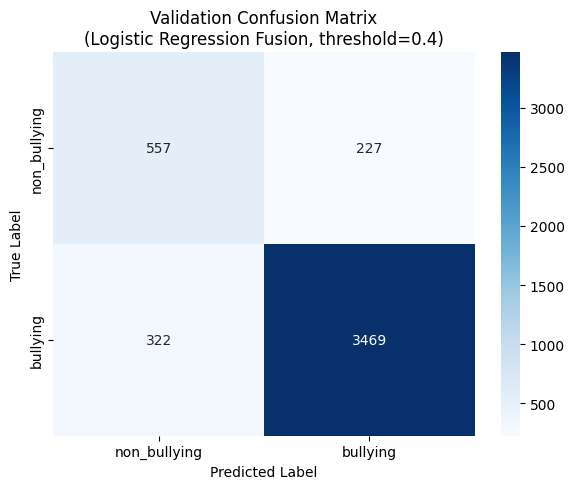


TEST METRICS (Logistic Regression Fusion)
Decision Threshold: 0.4
              precision    recall  f1-score   support

non_bullying       0.62      0.71      0.66       785
    bullying       0.94      0.91      0.92      3791

    accuracy                           0.88      4576
   macro avg       0.78      0.81      0.79      4576
weighted avg       0.88      0.88      0.88      4576

ROC-AUC (test): 0.9288077528575052

Confusion matrix (test):
[[ 560  225]
 [ 341 3450]]

Error Analysis:
  False Positive Rate (innocent flagged): 28.66% (225/785)
  False Negative Rate (bullying missed): 8.99% (341/3791)


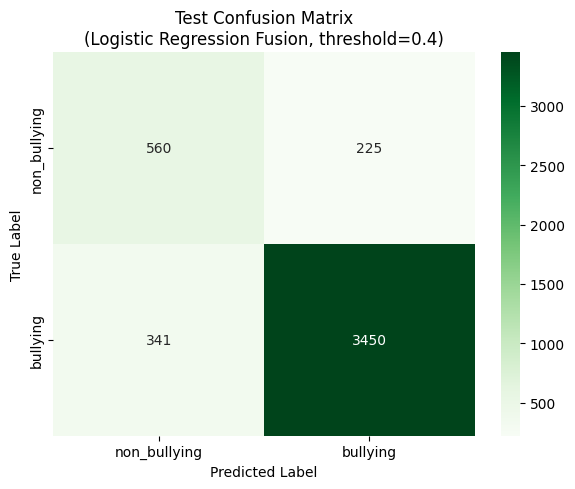

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

BULLY_LABEL = 'not_cyberbullying'
DECISION_THRESHOLD = 0.4 

numeric_cols = train_feats.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != 'label']


def build_matrix(df, emb):
    modal = df[feature_cols].to_numpy(dtype='float32', copy=True)
    if emb is not None:
        emb = emb.astype('float32')
        if emb.ndim == 1:
            emb = emb[:, None]
        modal = np.concatenate([modal, emb], axis=1)
    return modal


X_train = build_matrix(train_feats, train_emb)
X_val = build_matrix(val_feats, val_emb)
X_test = build_matrix(test_feats, test_emb) if test_feats is not None and test_emb is not None else None

y_train = (train_feats['label'].astype(str) != BULLY_LABEL).to_numpy(dtype='int32')
y_val = (val_feats['label'].astype(str) != BULLY_LABEL).to_numpy(dtype='int32')
y_test = (test_feats['label'].astype(str) != BULLY_LABEL).to_numpy(dtype='int32') if test_feats is not None else None

# Check class distribution
print("Class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls} ({'non_bullying' if cls == 0 else 'bullying'}): {cnt} samples ({cnt/len(y_train)*100:.2f}%)")

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test) if X_test is not None else None

fusion_clf = LogisticRegression(max_iter=1000, class_weight='balanced')
fusion_clf.fit(X_train_scaled, y_train)

# Get probabilities
val_prob = fusion_clf.predict_proba(X_val_scaled)[:, 1]
# Apply custom threshold
val_pred = (val_prob >= DECISION_THRESHOLD).astype('int32')

print('\n' + '='*60)
print('VALIDATION METRICS (Logistic Regression Fusion)')
print(f'Decision Threshold: {DECISION_THRESHOLD}')
print('='*60)
print(classification_report(y_val, val_pred, target_names=['non_bullying', 'bullying']))
print('ROC-AUC (val):', roc_auc_score(y_val, val_prob))
print('\nConfusion matrix (val):')
cm_val = confusion_matrix(y_val, val_pred)
print(cm_val)

# Calculate error rates
tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
fpr_val = fp_val / (fp_val + tn_val)  # False Positive Rate
fnr_val = fn_val / (fn_val + tp_val)  # False Negative Rate
print(f'\nError Analysis:')
print(f'  False Positive Rate (innocent flagged): {fpr_val:.2%} ({fp_val}/{fp_val + tn_val})')
print(f'  False Negative Rate (bullying missed): {fnr_val:.2%} ({fn_val}/{fn_val + tp_val})')

# Plot validation confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['non_bullying', 'bullying'],
            yticklabels=['non_bullying', 'bullying'], ax=ax)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title(f'Validation Confusion Matrix\n(Logistic Regression Fusion, threshold={DECISION_THRESHOLD})')
plt.tight_layout()
plt.show()

# Test set predictions with custom threshold
if X_test_scaled is not None:
    test_prob = fusion_clf.predict_proba(X_test_scaled)[:, 1]
    test_pred = (test_prob >= DECISION_THRESHOLD).astype('int32')
    
    print('\n' + '='*60)
    print('TEST METRICS (Logistic Regression Fusion)')
    print(f'Decision Threshold: {DECISION_THRESHOLD}')
    print('='*60)
    print(classification_report(y_test, test_pred, target_names=['non_bullying', 'bullying']))
    print('ROC-AUC (test):', roc_auc_score(y_test, test_prob))
    print('\nConfusion matrix (test):')
    cm_test = confusion_matrix(y_test, test_pred)
    print(cm_test)
    
    # Calculate error rates
    tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
    fpr_test = fp_test / (fp_test + tn_test)
    fnr_test = fn_test / (fn_test + tp_test)
    print(f'\nError Analysis:')
    print(f'  False Positive Rate (innocent flagged): {fpr_test:.2%} ({fp_test}/{fp_test + tn_test})')
    print(f'  False Negative Rate (bullying missed): {fnr_test:.2%} ({fn_test}/{fn_test + tp_test})')
    
    # Plot test confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=True,
                xticklabels=['non_bullying', 'bullying'],
                yticklabels=['non_bullying', 'bullying'], ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(f'Test Confusion Matrix\n(Logistic Regression Fusion, threshold={DECISION_THRESHOLD})')
    plt.tight_layout()
    plt.show()
else:
    test_pred = None
    test_prob = None
    print('\n[WARN] Test split unavailable; skipping test evaluation.')


In [14]:
from pathlib import Path

fusion_artifact_dir = Path('../artifacts/phase1/fusion')
fusion_artifact_dir.mkdir(parents=True, exist_ok=True)

joblib.dump({'scaler': scaler, 'model': fusion_clf, 'feature_cols': feature_cols}, fusion_artifact_dir / 'fusion_logreg.joblib')
print(f"Saved fusion model to {fusion_artifact_dir / 'fusion_logreg.joblib'}")

# Compute comprehensive metrics for validation
precision_val, recall_val, f1_val, support_val = precision_recall_fscore_support(
    y_val, val_pred, average=None
)

val_results = {
    'decision_threshold': DECISION_THRESHOLD,
    'roc_auc': float(roc_auc_score(y_val, val_prob)),
    'accuracy': float((val_pred == y_val).mean()),
    'precision_non_bullying': float(precision_val[0]),
    'recall_non_bullying': float(recall_val[0]),
    'f1_non_bullying': float(f1_val[0]),
    'support_non_bullying': int(support_val[0]),
    'precision_bullying': float(precision_val[1]),
    'recall_bullying': float(recall_val[1]),
    'f1_bullying': float(f1_val[1]),
    'support_bullying': int(support_val[1]),
    'macro_f1': float(f1_val.mean()),
    'weighted_f1': float(f1_score(y_val, val_pred, average='weighted')),
    'confusion_matrix': cm_val.tolist(),
    'false_positive_rate': float(fpr_val),
    'false_negative_rate': float(fnr_val),
}

metrics = {'validation': val_results}

if test_pred is not None and test_prob is not None:
    # Compute comprehensive metrics for test
    precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
        y_test, test_pred, average=None
    )
    
    test_results = {
        'decision_threshold': DECISION_THRESHOLD,
        'roc_auc': float(roc_auc_score(y_test, test_prob)),
        'accuracy': float((test_pred == y_test).mean()),
        'precision_non_bullying': float(precision_test[0]),
        'recall_non_bullying': float(recall_test[0]),
        'f1_non_bullying': float(f1_test[0]),
        'support_non_bullying': int(support_test[0]),
        'precision_bullying': float(precision_test[1]),
        'recall_bullying': float(recall_test[1]),
        'f1_bullying': float(f1_test[1]),
        'support_bullying': int(support_test[1]),
        'macro_f1': float(f1_test.mean()),
        'weighted_f1': float(f1_score(y_test, test_pred, average='weighted')),
        'confusion_matrix': cm_test.tolist(),
        'false_positive_rate': float(fpr_test),
        'false_negative_rate': float(fnr_test),
    }
    metrics['test'] = test_results

(fusion_artifact_dir / 'metrics.json').write_text(json.dumps(metrics, indent=2))

print('\n' + '='*60)
print('SAVED METRICS SUMMARY')
print('='*60)
print(f"Decision Threshold: {DECISION_THRESHOLD}")
print(f"Primary metric (ROC-AUC): {val_results['roc_auc']:.4f}")
print(f"Macro F1 (validation): {val_results['macro_f1']:.4f}")
print(f"Weighted F1 (validation): {val_results['weighted_f1']:.4f}")
print(f"FPR (validation): {val_results['false_positive_rate']:.2%}")
print(f"FNR (validation): {val_results['false_negative_rate']:.2%}")
if 'test' in metrics:
    print(f"Macro F1 (test): {metrics['test']['macro_f1']:.4f}")
    print(f"Weighted F1 (test): {metrics['test']['weighted_f1']:.4f}")
    print(f"FPR (test): {metrics['test']['false_positive_rate']:.2%}")
    print(f"FNR (test): {metrics['test']['false_negative_rate']:.2%}")
    print('\nSaved validation and test metrics to metrics.json')
else:
    print('\nSaved validation metrics to metrics.json (test split unavailable)')
print(f"Location: {fusion_artifact_dir / 'metrics.json'}")


Saved fusion model to ../artifacts/phase1/fusion/fusion_logreg.joblib

SAVED METRICS SUMMARY
Decision Threshold: 0.4
Primary metric (ROC-AUC): 0.9253
Macro F1 (validation): 0.7983
Weighted F1 (validation): 0.8827
FPR (validation): 28.95%
FNR (validation): 8.49%
Macro F1 (test): 0.7942
Weighted F1 (test): 0.8796
FPR (test): 28.66%
FNR (test): 8.99%

Saved validation and test metrics to metrics.json
Location: ../artifacts/phase1/fusion/metrics.json



Class weights for imbalance handling: {0: 2.9150207072316023, 1: 0.6035187811232398}
Epoch 1/40
286/286 - 19s - 67ms/step - accuracy: 0.9220 - loss: 0.2006 - roc_auc: 0.9759 - val_accuracy: 0.8800 - val_loss: 0.3411 - val_roc_auc: 0.9330
Epoch 2/40
286/286 - 13s - 44ms/step - accuracy: 0.8495 - loss: 62.5232 - roc_auc: 0.8744 - val_accuracy: 0.8544 - val_loss: 68.3410 - val_roc_auc: 0.8468
Epoch 3/40
286/286 - 14s - 49ms/step - accuracy: 0.7416 - loss: 36.5721 - roc_auc: 0.7013 - val_accuracy: 0.6184 - val_loss: 67.2173 - val_roc_auc: 0.7641
Epoch 4/40
286/286 - 12s - 42ms/step - accuracy: 0.6381 - loss: 16.4693 - roc_auc: 0.6207 - val_accuracy: 0.5814 - val_loss: 2.7249 - val_roc_auc: 0.5504
Epoch 5/40
286/286 - 13s - 44ms/step - accuracy: 0.6288 - loss: 14.8690 - roc_auc: 0.6383 - val_accuracy: 0.6334 - val_loss: 36.3288 - val_roc_auc: 0.7665
Epoch 6/40
286/286 - 12s - 43ms/step - accuracy: 0.6803 - loss: 4.9554 - roc_auc: 0.7132 - val_accuracy: 0.6507 - val_loss: 3.5829 - val_roc_a

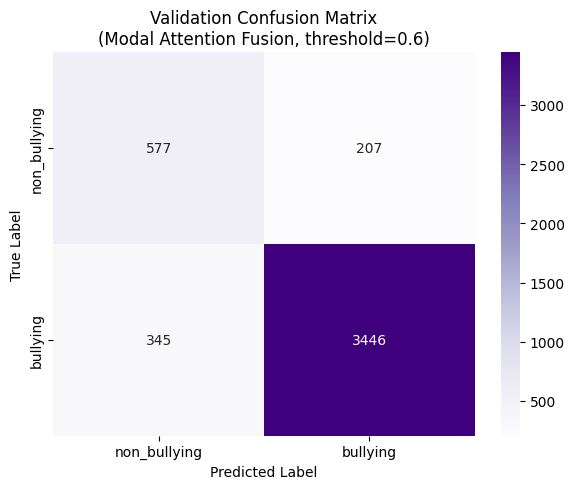

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

TEST METRICS (Modal Attention Fusion)
Decision Threshold: 0.6
              precision    recall  f1-score   support

non_bullying       0.63      0.74      0.68       785
    bullying       0.94      0.91      0.93      3791

    accuracy                           0.88      4576
   macro avg       0.79      0.83      0.80      4576
weighted avg       0.89      0.88      0.88      4576

ROC-AUC (test): 0.9398987209062026

Confusion matrix (test):
[[ 583  202]
 [ 348 3443]]

Error Analysis:
  False Positive Rate (innocent flagged): 25.73% (202/785)
  False Negative Rate (bullying missed): 9.18% (348/3791)


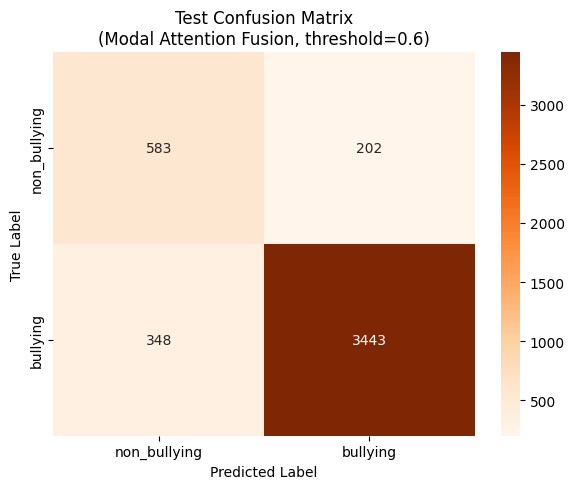


SAVED METRICS SUMMARY (Modal Attention)
Decision Threshold: 0.6
Primary metric (ROC-AUC): 0.9354
Macro F1 (validation): 0.8011
Weighted F1 (validation): 0.8831
FPR (validation): 26.40%
FNR (validation): 9.10%
Macro F1 (test): 0.8028
Weighted F1 (test): 0.8837
FPR (test): 25.73%
FNR (test): 9.18%

Saved modal attention model to ../artifacts/phase1/fusion/modal_attention/fusion_modal_attention.keras
Saved comprehensive metrics to ../artifacts/phase1/fusion/modal_attention/metrics.json


In [15]:
# Modal attention fusion (TensorFlow)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score
import json

ATTN_DIM = 128
NUM_HEADS = 4
ATTN_DROPOUT = 0.1
DENSE_DROPOUT = 0.3
DECISION_THRESHOLD = 0.6  # Adjusted threshold (default was 0.5)

modal_prefixes = {
    'text_prob': lambda c: c.startswith('prob_'),
    'face': lambda c: c.startswith('face_'),
    'audio': lambda c: c.startswith('audio_'),
    'lex': lambda c: c.startswith('lex_'),
    'emotion': lambda c: c.startswith('emotion_'),
}

def make_modal_arrays(df, emb):
    arrays = {}
    for name, matcher in modal_prefixes.items():
        cols = [c for c in feature_cols if matcher(c)]
        if cols:
            arrays[name] = df[cols].to_numpy(dtype='float32')
    residual_cols = [
        c for c in feature_cols
        if not any(matcher(c) for matcher in modal_prefixes.values())
    ]
    if residual_cols:
        arrays['other'] = df[residual_cols].to_numpy(dtype='float32')
    if emb is not None:
        arrays['text_emb'] = emb.astype('float32')
    return arrays

train_modal = make_modal_arrays(train_feats, train_emb)
val_modal = make_modal_arrays(val_feats, val_emb)
test_modal = make_modal_arrays(test_feats, test_emb) if test_feats is not None and test_emb is not None else None

shared_modalities = [name for name in train_modal if name in val_modal and train_modal[name].shape[1] > 0]
if test_modal is not None:
    shared_modalities = [name for name in shared_modalities if name in test_modal]

train_inputs = {f"{name}_input": train_modal[name] for name in shared_modalities}
val_inputs = {f"{name}_input": val_modal[name] for name in shared_modalities}
if test_modal is not None:
    test_inputs = {f"{name}_input": test_modal[name] for name in shared_modalities}
else:
    test_inputs = None

inputs = []
modal_tokens = []
for name in shared_modalities:
    input_layer = layers.Input(shape=(train_modal[name].shape[1],), name=f"{name}_input")
    projected = layers.Dense(ATTN_DIM, activation='relu', name=f"{name}_proj")(input_layer)
    token = layers.Reshape((1, ATTN_DIM), name=f"{name}_token")(projected)
    inputs.append(input_layer)
    modal_tokens.append(token)

if not modal_tokens:
    raise RuntimeError('No modality features available for attention fusion.')

if len(modal_tokens) > 1:
    modal_sequence = layers.Concatenate(axis=1, name='modal_sequence')(modal_tokens)
else:
    modal_sequence = modal_tokens[0]

attn_output = layers.MultiHeadAttention(
    num_heads=NUM_HEADS,
    key_dim=ATTN_DIM // NUM_HEADS,
    dropout=ATTN_DROPOUT,
    name='modal_attention',
)(modal_sequence, modal_sequence)
residual = layers.Add(name='attn_residual')([modal_sequence, attn_output])
pooled = layers.GlobalAveragePooling1D(name='modal_pool')(residual)
x = layers.Dropout(DENSE_DROPOUT, name='pre_dense_dropout')(pooled)
x = layers.Dense(ATTN_DIM, activation='relu', name='fusion_dense')(x)
x = layers.Dropout(DENSE_DROPOUT, name='post_dense_dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='bullying_prob')(x)

attention_model = keras.Model(inputs=inputs, outputs=output, name='modal_attention_fusion')
attention_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='roc_auc'), 'accuracy'],
)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_map = {int(c): float(w) for c, w in zip(np.unique(y_train), class_weights)}

print(f"\nClass weights for imbalance handling: {class_weight_map}")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_roc_auc',
        mode='max',
        patience=5,
        restore_best_weights=True,
    )
]

history = attention_model.fit(
    train_inputs,
    y_train,
    validation_data=(val_inputs, y_val),
    epochs=40,
    batch_size=128,
    class_weight=class_weight_map,
    callbacks=callbacks,
    verbose=2,
)

val_probs_attn = attention_model.predict(val_inputs, batch_size=256)
# Apply custom threshold
val_pred_attn = (val_probs_attn >= DECISION_THRESHOLD).astype('int32').ravel()

print('\n' + '='*60)
print('VALIDATION METRICS (Modal Attention Fusion)')
print(f'Decision Threshold: {DECISION_THRESHOLD}')
print('='*60)
print(classification_report(y_val, val_pred_attn, target_names=['non_bullying', 'bullying']))
print('ROC-AUC (val):', roc_auc_score(y_val, val_probs_attn.ravel()))

cm_val_attn = confusion_matrix(y_val, val_pred_attn)
print('\nConfusion matrix (val):')
print(cm_val_attn)

# Calculate error rates
tn_val_attn, fp_val_attn, fn_val_attn, tp_val_attn = cm_val_attn.ravel()
fpr_val_attn = fp_val_attn / (fp_val_attn + tn_val_attn)
fnr_val_attn = fn_val_attn / (fn_val_attn + tp_val_attn)
print(f'\nError Analysis:')
print(f'  False Positive Rate (innocent flagged): {fpr_val_attn:.2%} ({fp_val_attn}/{fp_val_attn + tn_val_attn})')
print(f'  False Negative Rate (bullying missed): {fnr_val_attn:.2%} ({fn_val_attn}/{fn_val_attn + tp_val_attn})')

# Plot validation confusion matrix for attention model
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(cm_val_attn, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['non_bullying', 'bullying'],
            yticklabels=['non_bullying', 'bullying'], ax=ax)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title(f'Validation Confusion Matrix\n(Modal Attention Fusion, threshold={DECISION_THRESHOLD})')
plt.tight_layout()
plt.show()

if test_inputs is not None:
    test_probs_attn = attention_model.predict(test_inputs, batch_size=256)
    # Apply custom threshold
    test_pred_attn = (test_probs_attn >= DECISION_THRESHOLD).astype('int32').ravel()
    
    print('\n' + '='*60)
    print('TEST METRICS (Modal Attention Fusion)')
    print(f'Decision Threshold: {DECISION_THRESHOLD}')
    print('='*60)
    print(classification_report(y_test, test_pred_attn, target_names=['non_bullying', 'bullying']))
    print('ROC-AUC (test):', roc_auc_score(y_test, test_probs_attn.ravel()))
    
    cm_test_attn = confusion_matrix(y_test, test_pred_attn)
    print('\nConfusion matrix (test):')
    print(cm_test_attn)
    
    # Calculate error rates
    tn_test_attn, fp_test_attn, fn_test_attn, tp_test_attn = cm_test_attn.ravel()
    fpr_test_attn = fp_test_attn / (fp_test_attn + tn_test_attn)
    fnr_test_attn = fn_test_attn / (fn_test_attn + tp_test_attn)
    print(f'\nError Analysis:')
    print(f'  False Positive Rate (innocent flagged): {fpr_test_attn:.2%} ({fp_test_attn}/{fp_test_attn + tn_test_attn})')
    print(f'  False Negative Rate (bullying missed): {fnr_test_attn:.2%} ({fn_test_attn}/{fn_test_attn + tp_test_attn})')
    
    # Plot test confusion matrix for attention model
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    sns.heatmap(cm_test_attn, annot=True, fmt='d', cmap='Oranges', cbar=True,
                xticklabels=['non_bullying', 'bullying'],
                yticklabels=['non_bullying', 'bullying'], ax=ax)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(f'Test Confusion Matrix\n(Modal Attention Fusion, threshold={DECISION_THRESHOLD})')
    plt.tight_layout()
    plt.show()
else:
    test_probs_attn = None
    test_pred_attn = None

attention_dir = fusion_artifact_dir / 'modal_attention'
attention_dir.mkdir(parents=True, exist_ok=True)
attention_model.save(attention_dir / 'fusion_modal_attention.keras')
np.save(attention_dir / 'val_probabilities.npy', val_probs_attn.ravel())
if test_probs_attn is not None:
    np.save(attention_dir / 'test_probabilities.npy', test_probs_attn.ravel())

# Compute comprehensive metrics for validation
precision_val_attn, recall_val_attn, f1_val_attn, support_val_attn = precision_recall_fscore_support(
    y_val, val_pred_attn, average=None
)

metrics_attn = {
    'validation': {
        'decision_threshold': DECISION_THRESHOLD,
        'roc_auc': float(roc_auc_score(y_val, val_probs_attn.ravel())),
        'accuracy': float((val_pred_attn == y_val).mean()),
        'precision_non_bullying': float(precision_val_attn[0]),
        'recall_non_bullying': float(recall_val_attn[0]),
        'f1_non_bullying': float(f1_val_attn[0]),
        'support_non_bullying': int(support_val_attn[0]),
        'precision_bullying': float(precision_val_attn[1]),
        'recall_bullying': float(recall_val_attn[1]),
        'f1_bullying': float(f1_val_attn[1]),
        'support_bullying': int(support_val_attn[1]),
        'macro_f1': float(f1_val_attn.mean()),
        'weighted_f1': float(f1_score(y_val, val_pred_attn, average='weighted')),
        'confusion_matrix': cm_val_attn.tolist(),
        'false_positive_rate': float(fpr_val_attn),
        'false_negative_rate': float(fnr_val_attn),
    }
}

if test_pred_attn is not None:
    # Compute comprehensive metrics for test
    precision_test_attn, recall_test_attn, f1_test_attn, support_test_attn = precision_recall_fscore_support(
        y_test, test_pred_attn, average=None
    )
    
    metrics_attn['test'] = {
        'decision_threshold': DECISION_THRESHOLD,
        'roc_auc': float(roc_auc_score(y_test, test_probs_attn.ravel())),
        'accuracy': float((test_pred_attn == y_test).mean()),
        'precision_non_bullying': float(precision_test_attn[0]),
        'recall_non_bullying': float(recall_test_attn[0]),
        'f1_non_bullying': float(f1_test_attn[0]),
        'support_non_bullying': int(support_test_attn[0]),
        'precision_bullying': float(precision_test_attn[1]),
        'recall_bullying': float(recall_test_attn[1]),
        'f1_bullying': float(f1_test_attn[1]),
        'support_bullying': int(support_test_attn[1]),
        'macro_f1': float(f1_test_attn.mean()),
        'weighted_f1': float(f1_score(y_test, test_pred_attn, average='weighted')),
        'confusion_matrix': cm_test_attn.tolist(),
        'false_positive_rate': float(fpr_test_attn),
        'false_negative_rate': float(fnr_test_attn),
    }

(attention_dir / 'metrics.json').write_text(json.dumps(metrics_attn, indent=2))

print('\n' + '='*60)
print('SAVED METRICS SUMMARY (Modal Attention)')
print('='*60)
print(f"Decision Threshold: {DECISION_THRESHOLD}")
print(f"Primary metric (ROC-AUC): {metrics_attn['validation']['roc_auc']:.4f}")
print(f"Macro F1 (validation): {metrics_attn['validation']['macro_f1']:.4f}")
print(f"Weighted F1 (validation): {metrics_attn['validation']['weighted_f1']:.4f}")
print(f"FPR (validation): {metrics_attn['validation']['false_positive_rate']:.2%}")
print(f"FNR (validation): {metrics_attn['validation']['false_negative_rate']:.2%}")
if 'test' in metrics_attn:
    print(f"Macro F1 (test): {metrics_attn['test']['macro_f1']:.4f}")
    print(f"Weighted F1 (test): {metrics_attn['test']['weighted_f1']:.4f}")
    print(f"FPR (test): {metrics_attn['test']['false_positive_rate']:.2%}")
    print(f"FNR (test): {metrics_attn['test']['false_negative_rate']:.2%}")
print(f"\nSaved modal attention model to {attention_dir / 'fusion_modal_attention.keras'}")
print(f"Saved comprehensive metrics to {attention_dir / 'metrics.json'}")
